In [34]:
!pip install sentiment_analysis_spanish

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Generamos el DF con la informacion que necesitamos

In [35]:
import pandas as pd
from sentiment_analysis_spanish import sentiment_analysis
import seaborn as sns
import matplotlib.pyplot as plt

df2=pd.read_csv('data.csv')

#### A

In [36]:
def get_different_columns(df1, df2):
    columns1 = set(df1.columns)
    columns2 = set(df2.columns)
    different_columns = list(columns1.symmetric_difference(columns2))
    return different_columns

In [37]:
def remove_values_from_list(lst, values_to_remove):
    for value in values_to_remove:
        if value in lst:
            lst.remove(value)
    return lst

In [38]:
def drop_first_row_and_concatenate(list_of_dfs, col_names):
    concatenated_df = pd.DataFrame()  # Empty DataFrame for concatenation

    for df in list_of_dfs:
        df = df.drop(0).reset_index(drop=True)  # Drop first row and reset index
        concatenated_df = pd.concat([concatenated_df, df], ignore_index=True)  # Concatenate

    
    concatenated_df = concatenated_df.rename(columns=dict(zip(concatenated_df.columns, col_names)))

    return concatenated_df

# Transformacion de los datos

## Funciones útiles

In [39]:
#Generar lista para cambiar columnas multiple choice
def encontrar_columnas_multiple_choice(df):
    target_texts = ['\n5 Totalmente de Acuerdo', '\n5 Muy Satisfecho']
    columns_with_text = []

    for column_name in df.columns:
        if df[column_name].astype(str).str.contains('|'.join(target_texts), na=False).any():
            columns_with_text.append(column_name)

    return columns_with_text

In [40]:
#funcion para convertir columna del tipo objeto a numerica
def convertir_numerico(df, column_list):
    for column in column_list:
        df[column] = pd.to_numeric(df[column], errors='coerce')

In [41]:
#cambiar los valores de las columnas multiple choice
def transformar_valores_multiple_choice(df, column_names):
    for column_name in column_names:
        df[column_name] = df[column_name].map({
            '\n5 Muy Satisfecho': 5,
            '4': 4,
            '3':3,
            '2':2,
            '\n1 Nada Satisfecho':1

        }).fillna(df[column_name])
    
    convertir_numerico(df, column_names)
    
    return df

In [42]:
#convertir comentarios a numerico con sentiment analysis model
def analisis_de_sentimiento(df, column_names):
    # Load the sentiment analysis model
    model = sentiment_analysis.SentimentAnalysisSpanish()

    for column_name in column_names:
        for index, row in df.iterrows():
            text = row[column_name]
            if pd.notnull(text):  # Skip NaN values
                sentiment = model.sentiment(text)
                df.at[index, column_name] = sentiment
    
    convertir_numerico(df, column_names)
    
    return df

In [43]:
# Funcion que calcula el promedio, la mediana, el valor maximo, el valor mínimo, la varianza y la desviación estandar de del df
def calculate_statistics(df):
    numericas = df.select_dtypes(include='number').columns

    statistics = pd.DataFrame()

    for column in numericas:
        column_stats = df[column].agg(['mean', 'median', 'max', 'min', 'var', 'std'])
        statistics = pd.concat([statistics, column_stats], axis=1)

    return statistics.T

In [44]:
# Se crea la tabla de frecuencias para cada pregunta del df
def tabla_de_frecuencia(df):
    columnas_categoricas = df.select_dtypes(exclude='number').columns
    columnas_categoricas = [col for col in columnas_categoricas if col not in ['OSF', 'Fecha']]

    tabla_de_frecuencia_moda = pd.DataFrame()

    for column in columnas_categoricas:
        if column != 'OSF':
            frecuencia_columna = df[column].value_counts().reset_index()
            frecuencia_columna.columns = [column, 'Frequency']
            moda_columna = df[column].mode().values.tolist()

            tabla_de_frecuencia_moda = pd.concat([tabla_de_frecuencia_moda, frecuencia_columna], axis=1)
            tabla_de_frecuencia_moda[column + ' (Mode)'] = moda_columna[0] if moda_columna else None

    return columnas_categoricas,tabla_de_frecuencia_moda

In [45]:
# Crea gráficas de bigote para cada pregunta con valores numericos
def boxplot_graf(df):
    numericas = df.select_dtypes(include='number').columns

    for column in numericas:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=df[column])
        plt.title(f"Boxplot de {column}")
        plt.xlabel(column)
        plt.ylabel('Valor')
        plt.show()

In [46]:
# Crea histograma para cada pregunta con valores numericos
def histograma_graf(df):
    numericas = df.select_dtypes(include='number').columns

    for column in numericas:
        plt.figure(figsize=(8, 6))
        plt.hist(df[column], bins='auto', edgecolor='black')
        plt.axvline(df[column].mean(), color='red', linestyle='dashed', linewidth=2)
        plt.title(f"Histograma de {column}")
        plt.xlabel(column)
        plt.ylabel("Frecuencia")
        plt.legend(["Promedio"])
        plt.show()

In [47]:
# Genera matriz de correlacion para las variables numericas
def Analisis_de_correlacion(df):
    numericas = df.select_dtypes(include='number').columns
    matriz_de_correlacion = df[numericas].corr()
    #print(matriz_de_correlacion)
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz_de_correlacion, annot=True, cmap='coolwarm')
    plt.title("Matriz de Correlacion")
    plt.show()

In [48]:
# Crea gráficas de barras para cada pregunta con valores categóricas
def Grafica_barra(df):
    categoricas = df.select_dtypes(include='object').columns
    categoricas = [col for col in categoricas if col not in ['OSF', 'Fecha']]
    for column in categoricas:
        plt.figure(figsize=(8, 6))
        df[column].value_counts().plot(kind='bar')
        plt.title(f"Grafica de Barra de {column}")
        plt.xlabel(column)
        plt.ylabel("Cuenta")
        plt.show()

In [49]:
# Crea gráficas de pay para cada pregunta con valores categóricas
def grafica_pie(df):
    categoricas = df.select_dtypes(include='object').columns
    categoricas = [col for col in categoricas if col not in ['OSF', 'Fecha']]

    for column in categoricas:
        plt.figure(figsize=(8, 6))
        counts = df[column].value_counts()
        plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
        plt.title(f"Grafica Pie  {column}")
        plt.show()

In [50]:
# Convierte las columnas categorcas en formato binario
def one_hot_encode(df):
    columnas_categoricas = df.select_dtypes(include='object').columns
    columnas_categoricas = [col for col in columnas_categoricas if col not in ['OSF', 'Fecha']]
    print(columnas_categoricas)
    df = pd.get_dummies(df, columns=columnas_categoricas)
    
    df = df.replace({True: 1, False: 0})
    
    return df

In [51]:
# Remplaza los valores nulos con el promedio de la encuesta por cada OSF
def replace_nan_with_average(df, columnas, OSF):
    for column in columnas:
        average_by_osf = df.groupby(OSF)[column].transform('mean')
        df[column].fillna(average_by_osf, inplace=True)
    
    return df

In [52]:
# Verificar cuantos valores nan hay en las columnas
def columnas_nan(df):
    nan_columnas = []

    for column in df.columns:
        nan_count = df[column].isna().sum()
        if nan_count > 0:
            nan_columnas.append(column)
    
    return nan_columnas

# Imprime las columnas que tiene valores nulos y cuanta cuantos tiene
def print_nan_values(df):
    nan_columnas = columnas_nan(df)
    print('Las columnas con NaN values son las siguientes:')
    for column in nan_columnas:
        nan_count = df[column].isna().sum()
        print(f"La columna '{column}': {nan_count} NaN values")
        print('_____________________________________')
    
    return nan_columnas


## Código de la transformacion

In [53]:
# Quitamos lo extra
complete_df = df2.drop('Duración (en segundos)', axis = 1)

#Sustituimos valores de tipo de comentario
aux = complete_df.iloc[:, 18]
aux = aux.map({
            'Reconocimiento' : 1,
            'Área de oportunidad': -1,
        })

# Lo borramos de la bd
complete_df = complete_df.drop('Q17', axis = 1)
# Encuentra las columnsas multiple choise y cmabia algunos datos que no eran numericos a numericos

lista_multiple_choice=encontrar_columnas_multiple_choice(complete_df)
df=transformar_valores_multiple_choice(complete_df, lista_multiple_choice)



# Análisis de sentimientos Para la pregunta 4 y pregunta 6 las cuales tienen texto escrito por los alumnos
list_columnas_analisis_sentimiento=['Q11','Q16']
df=analisis_de_sentimiento(df, list_columnas_analisis_sentimiento)

# Se juntan
df = pd.concat([df, aux], axis = 1)

df = df.drop('Fecha registrada', axis = 1)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Calculamos los estadísticos

In [54]:
# Se crea la matriz de estadísitcos y se gurada en un csv
estadistico_column=calculate_statistics(df)
estadistico_column.to_csv('tabladeestadisticos.csv')

### Creamos la tabla de frecuencia

In [55]:
# Se crea la tabla de frecuencias para cada pregunta y se almacena en un csv
columnas_categoricas,tabla_frecuencia=tabla_de_frecuencia(df)
tabla_frecuencia.to_csv('tabladefrecuencia.csv')

### Creamos los boxplots de cada pregunta

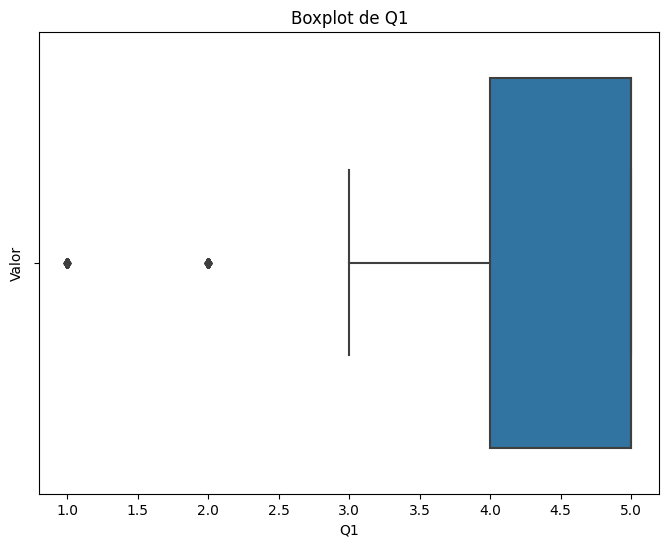

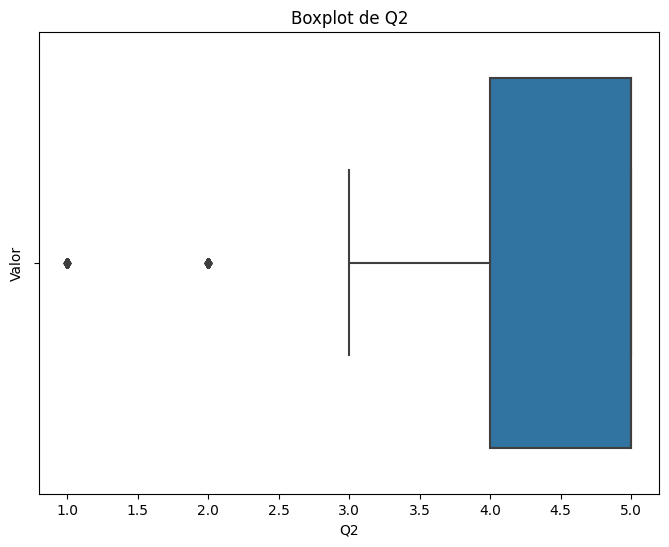

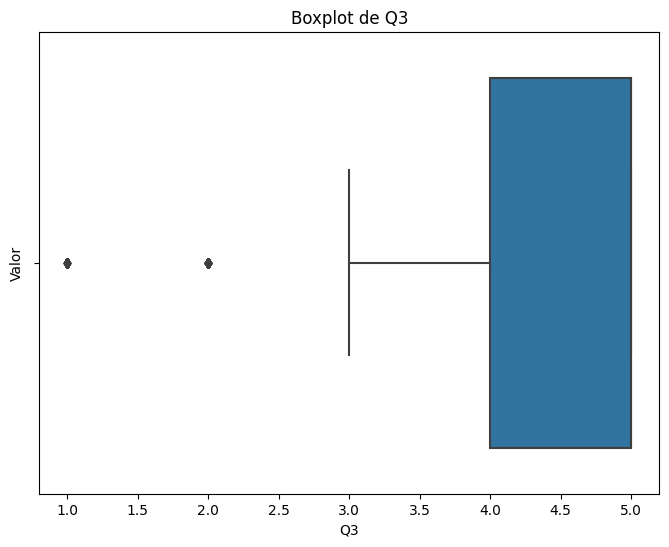

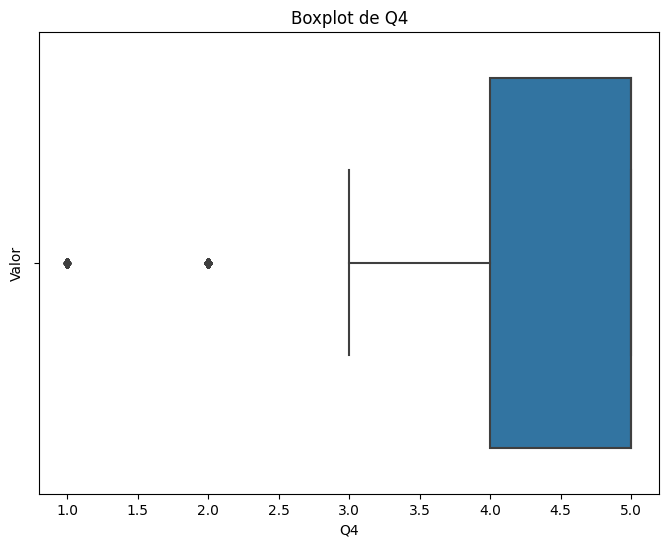

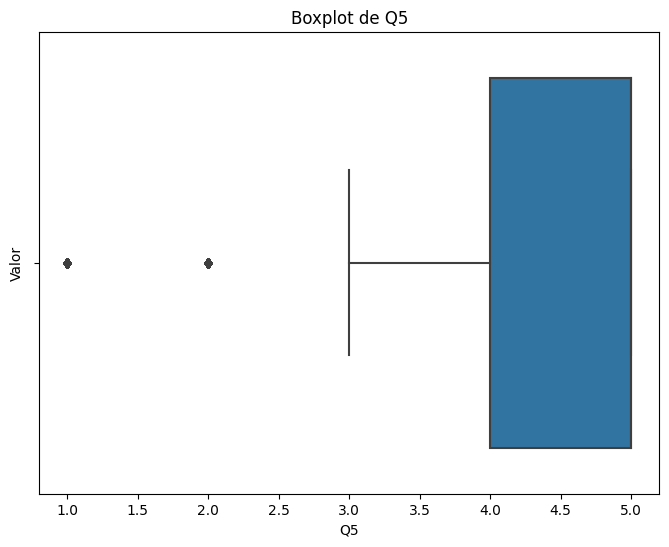

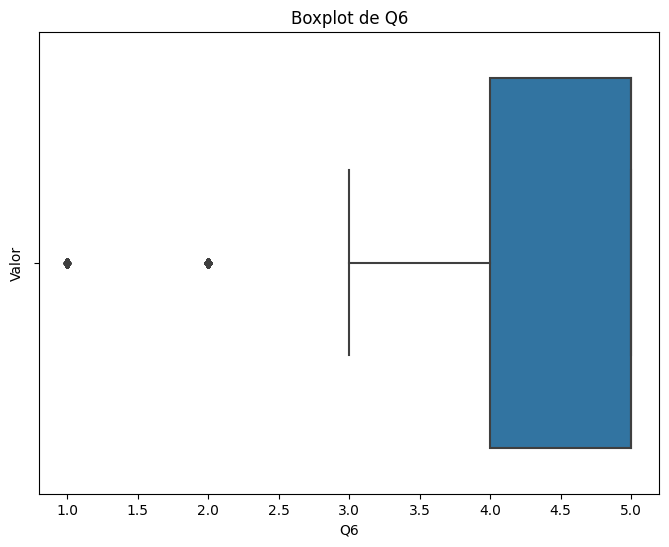

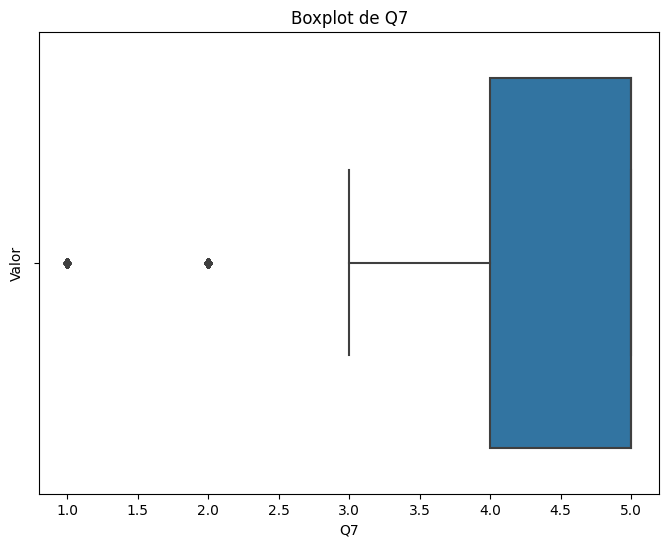

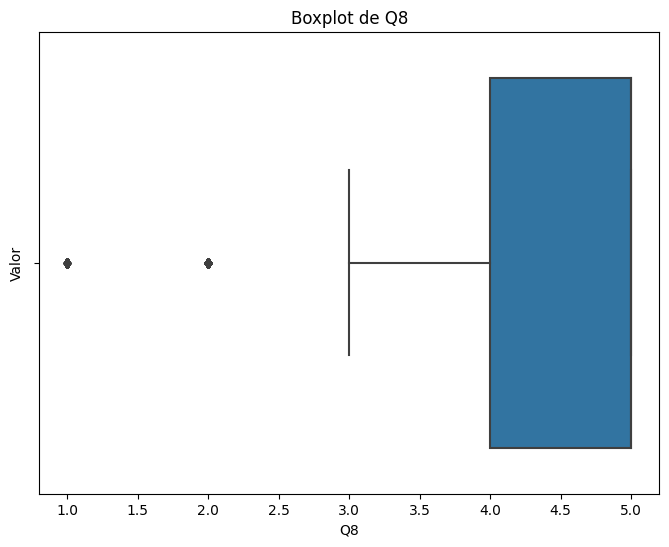

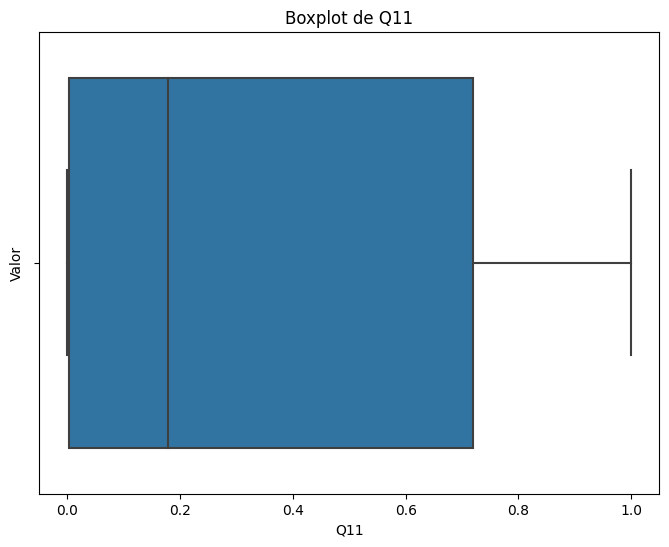

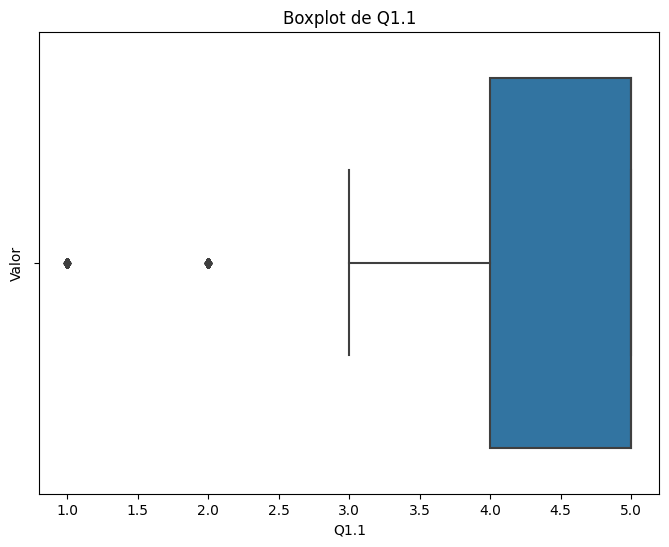

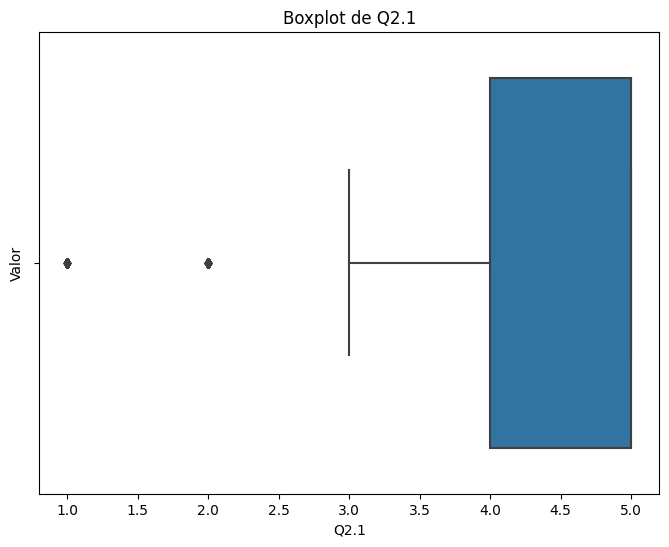

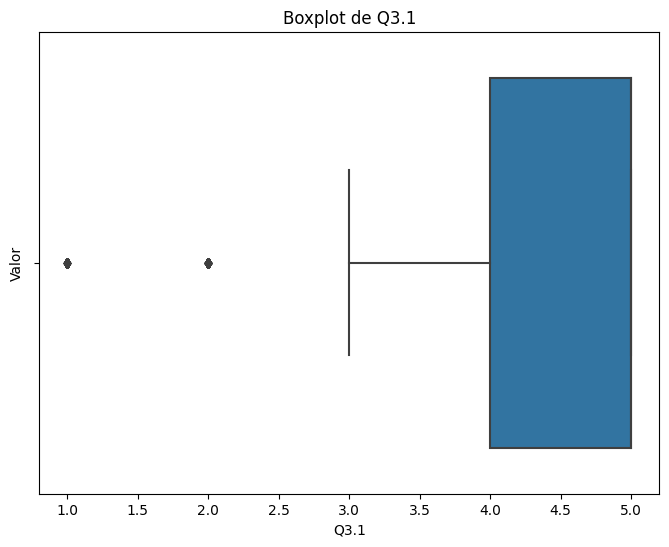

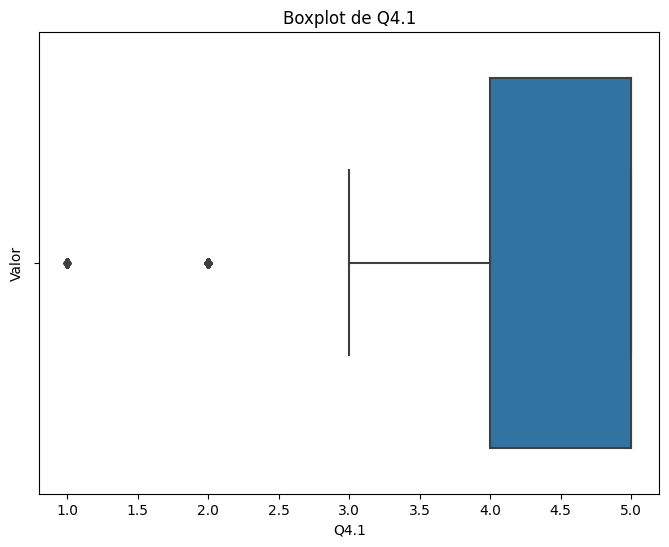

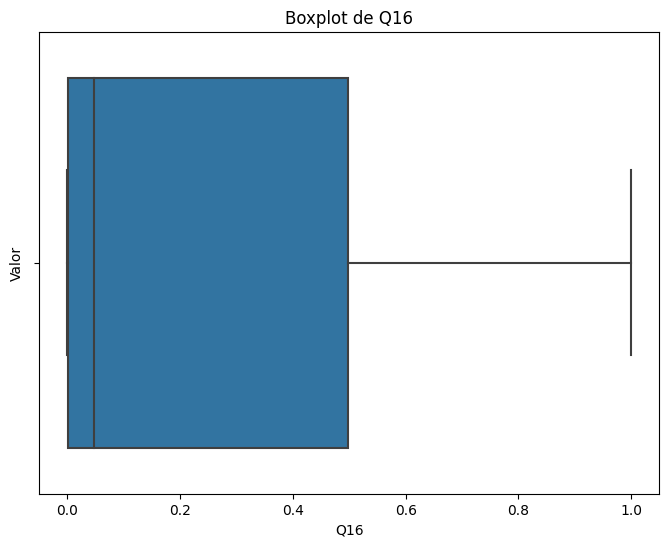

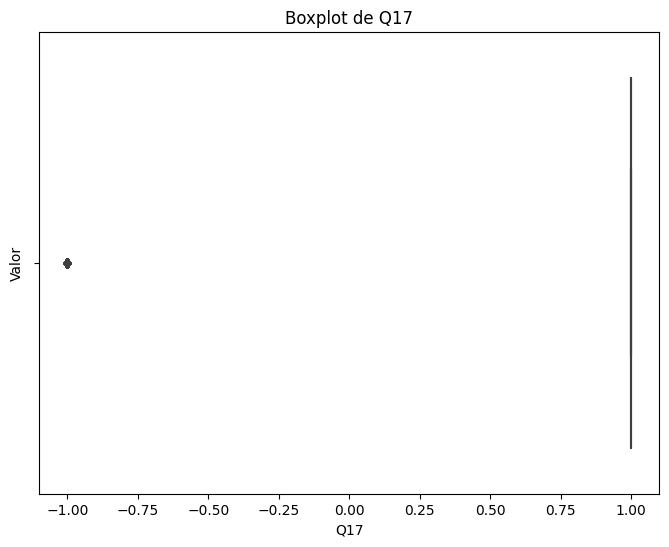

In [56]:
boxplot_graf(df)

### Creamos los histogramas de cada pregunta

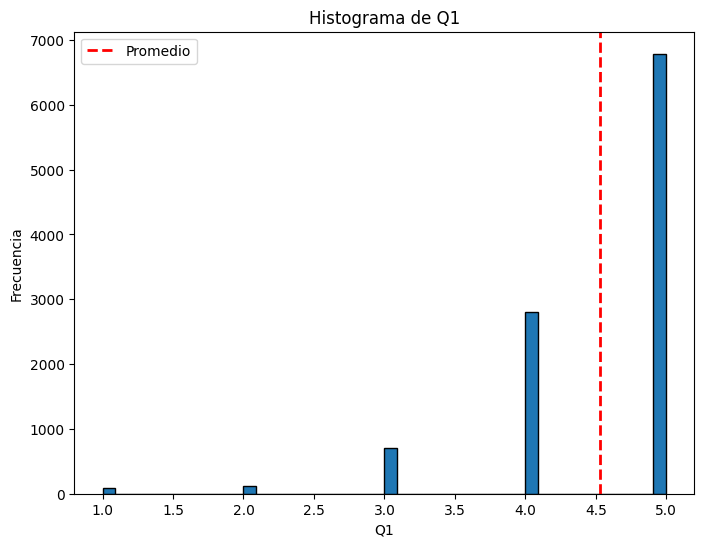

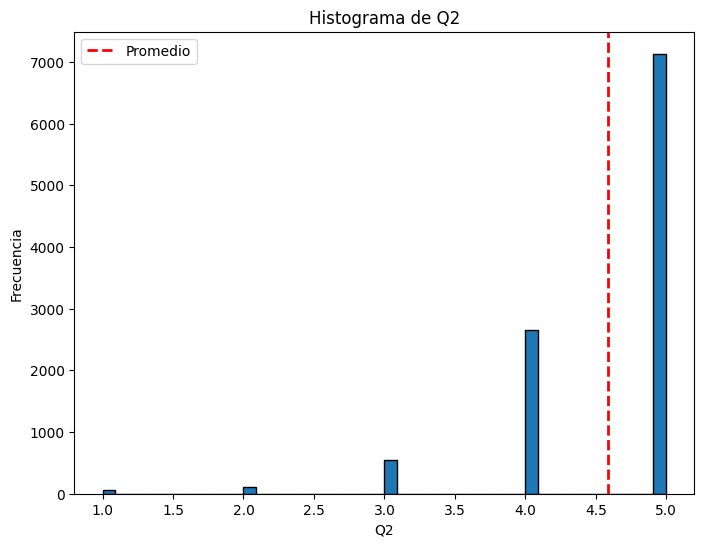

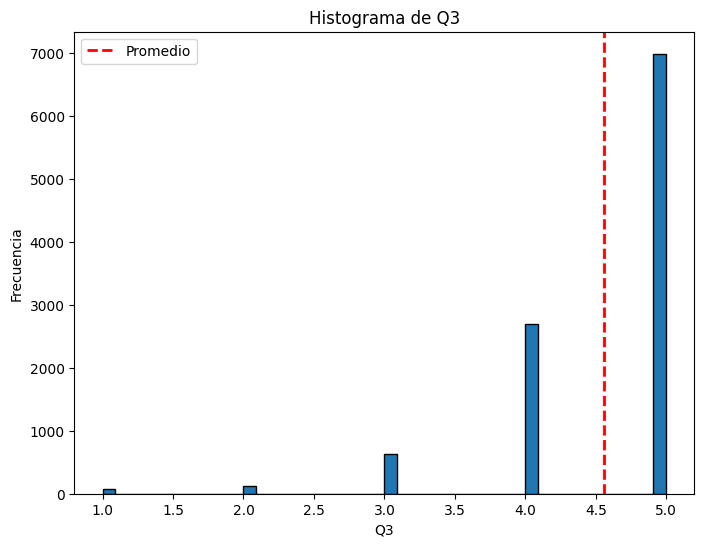

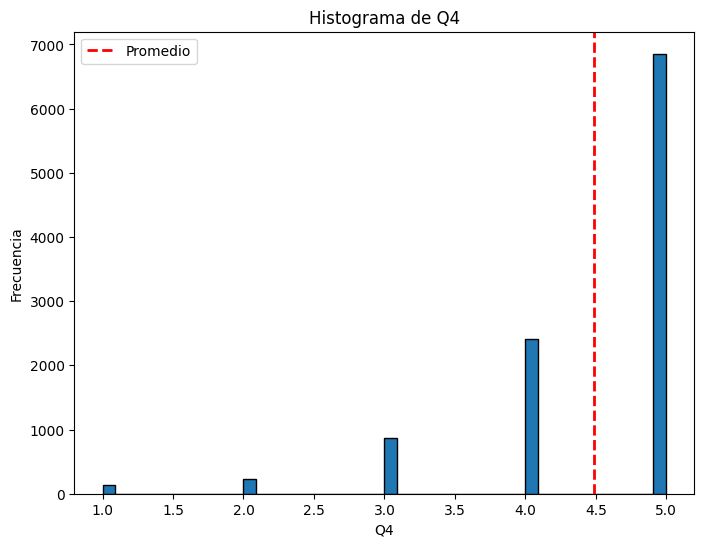

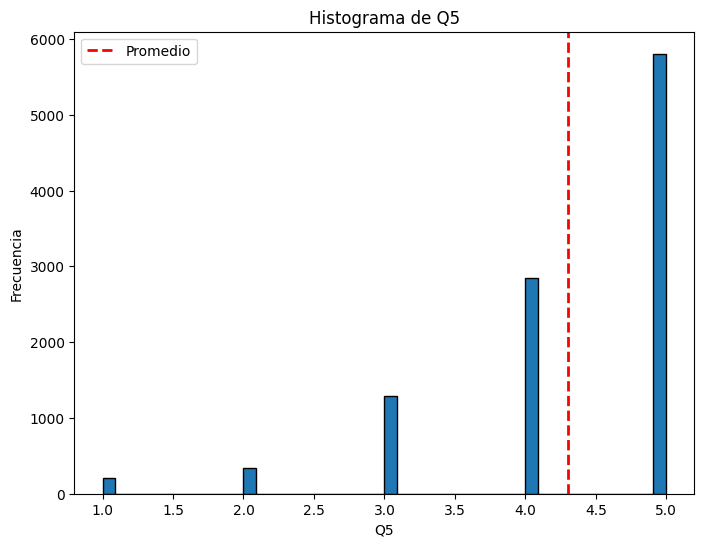

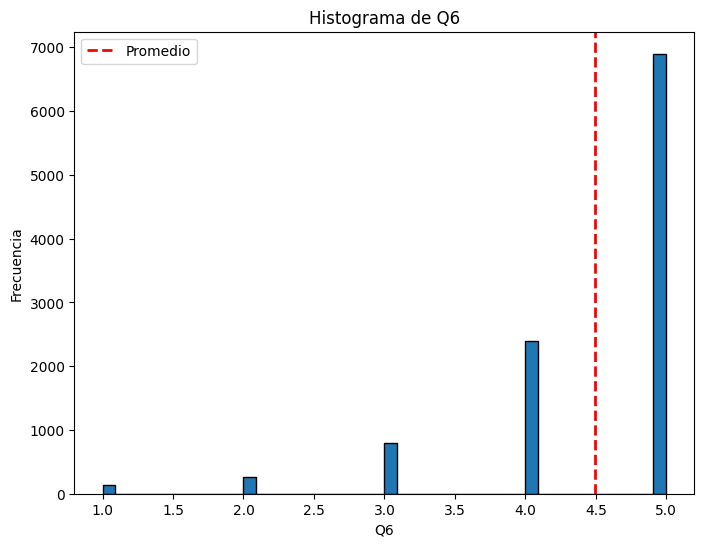

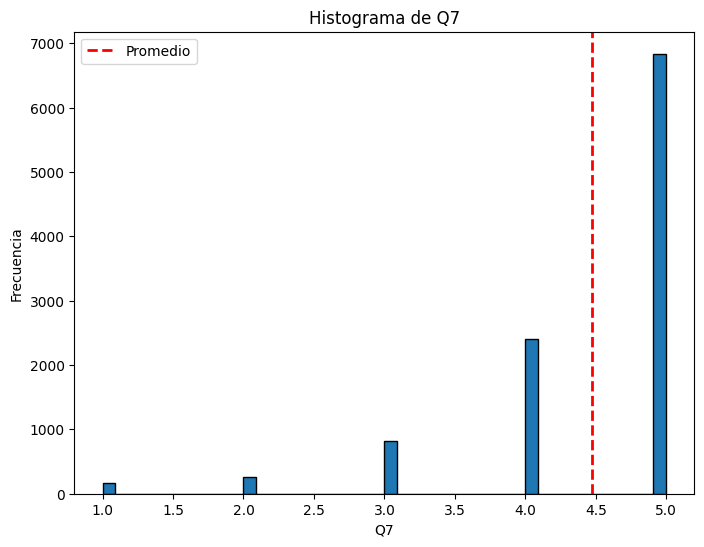

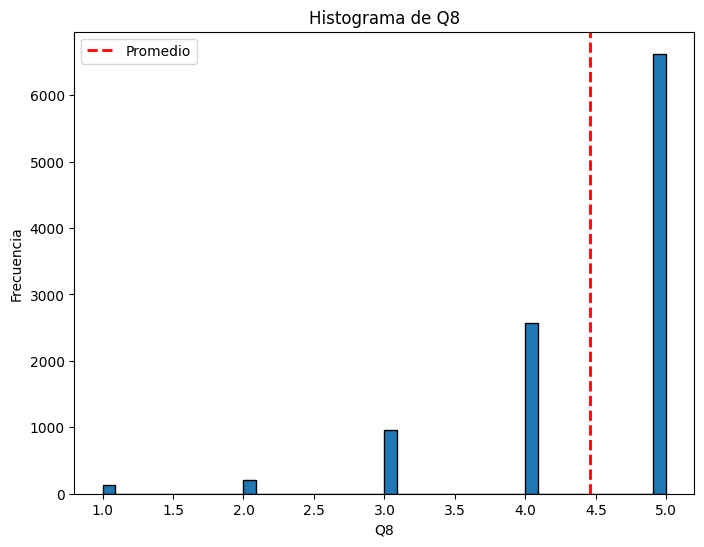

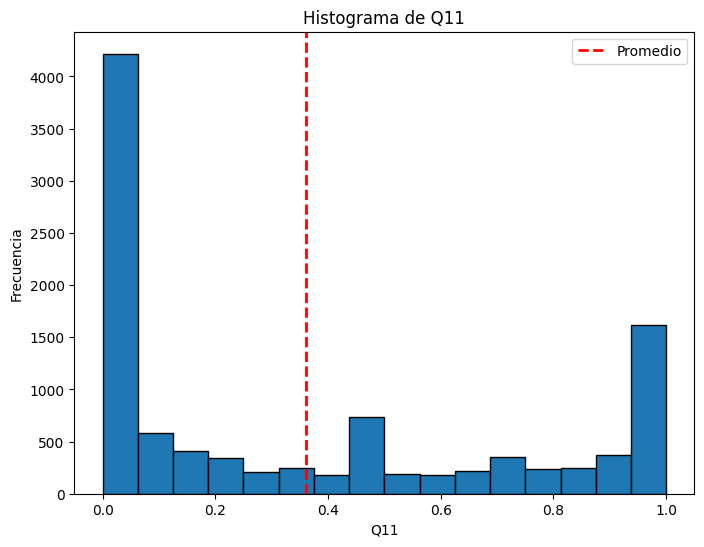

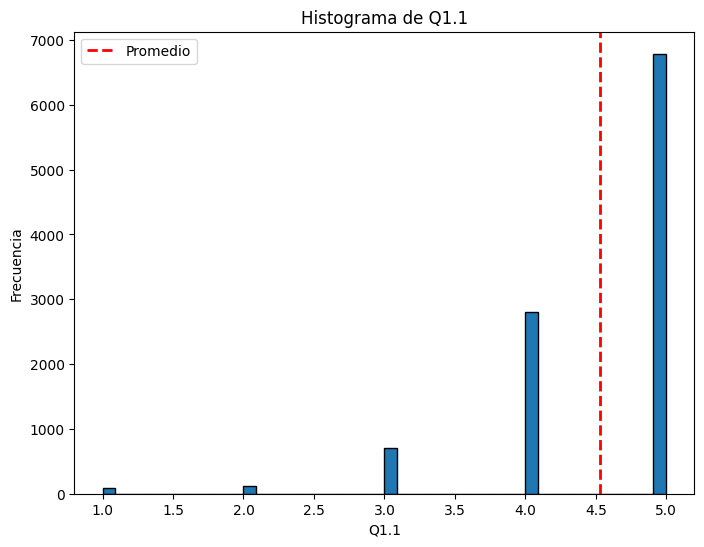

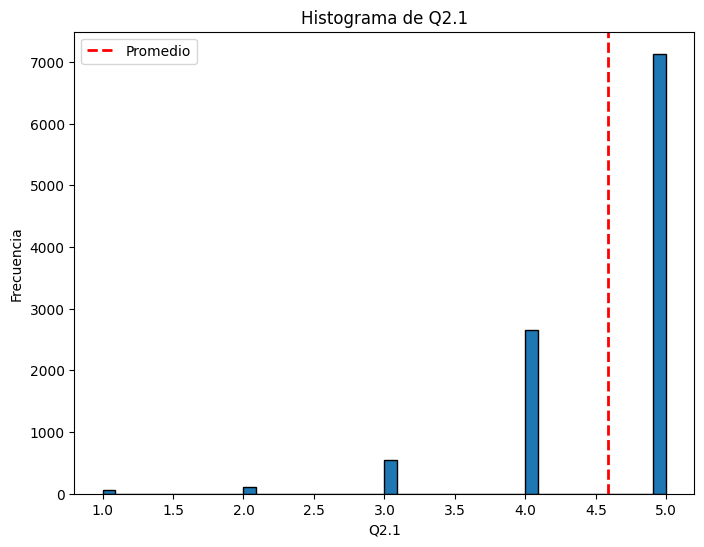

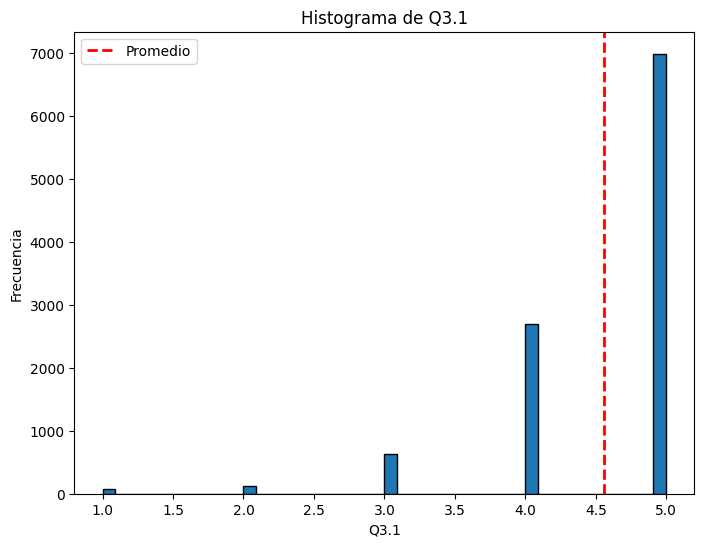

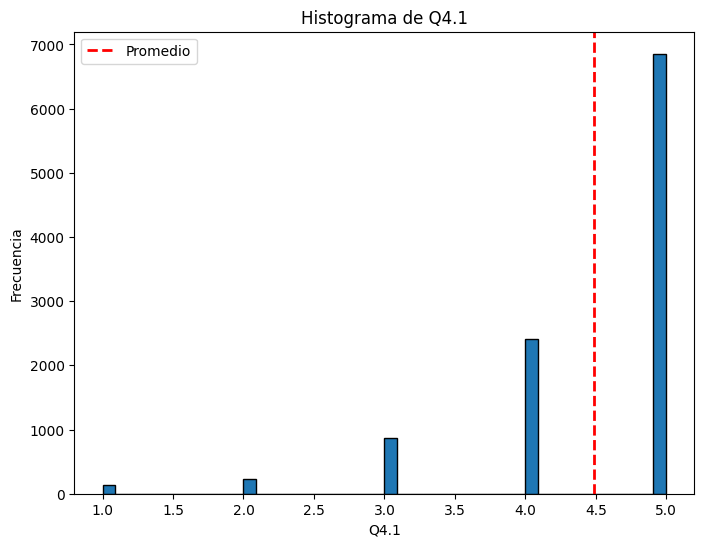

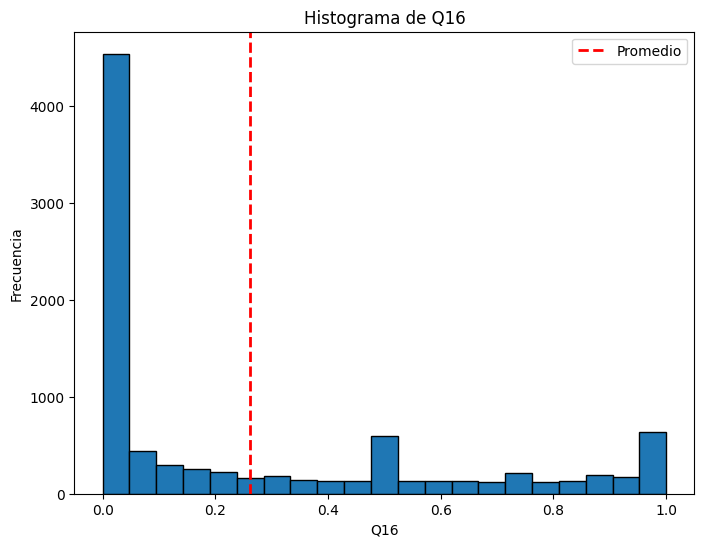

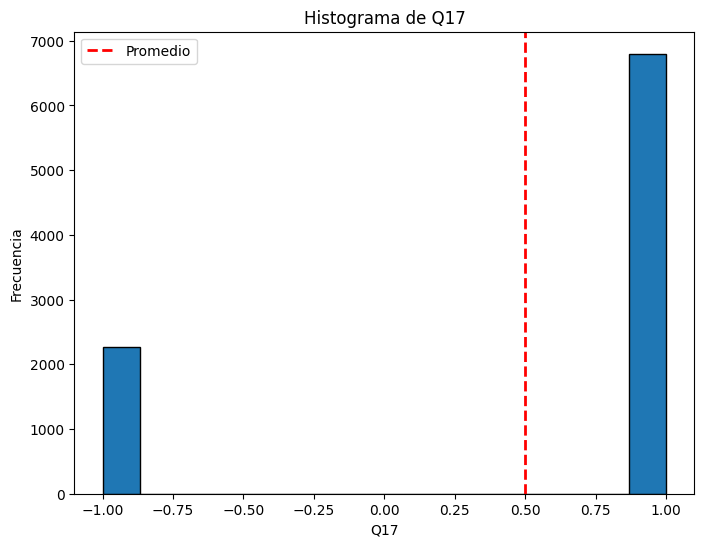

In [57]:
histograma_graf(df)

### Creamos la matriz de correlación


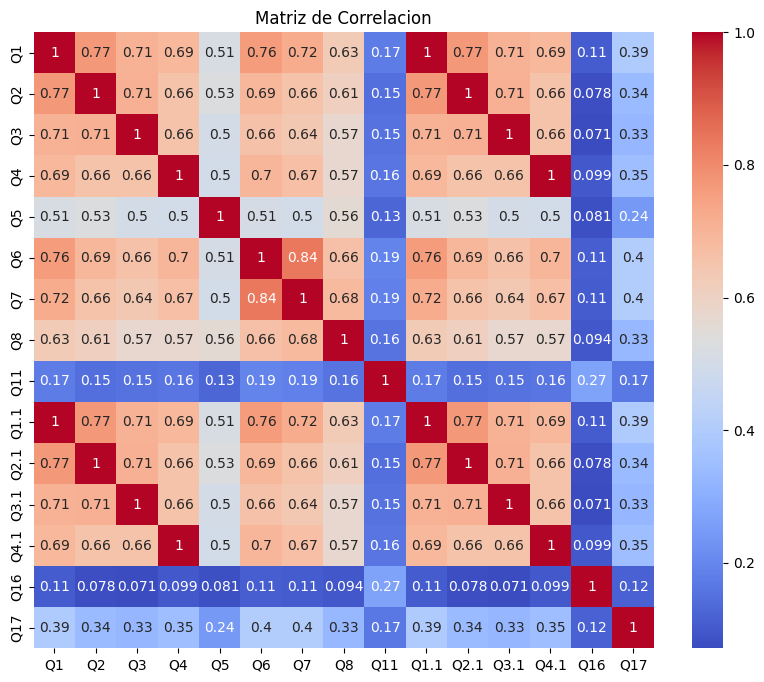

In [58]:
Analisis_de_correlacion(df)

### Greamos la gráfica de barras para las variables categóricas

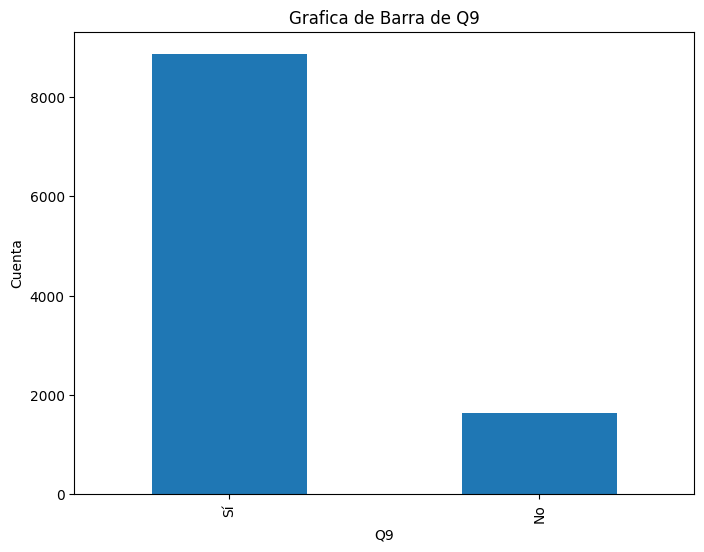

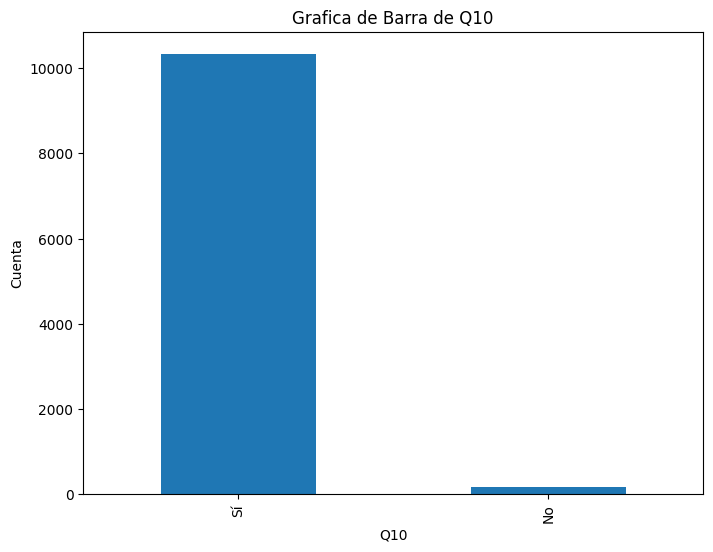

In [59]:
Grafica_barra(df)

# Limpieza de los datos

In [60]:
# representamos las variables categórcas en formato binario
df= one_hot_encode(df)

['Q9', 'Q10']


In [61]:
# Se buscan los valors nulos y se remplazan por promedios de las encuestas
columnas_con_nan_values=columnas_nan(df)
columnas_con_nan_values = columnas_con_nan_values[1:]
df = replace_nan_with_average(df, columnas_con_nan_values, 'OSF')


In [62]:
df

,OSF,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q11,Q1.1,Q2.1,Q3.1,Q4.1,Q16,Q17,Q9_No,Q9_Sí,Q10_No,Q10_Sí
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,León Ortigosa ABP,4.0,5.0,4.0,5.0,4.0,5.0,5.0,5.0,0.023311,4.0,5.0,4.0,5.0,1.035823e-02,1.000000,0,1,0,1
2,"Comenzar de Nuevo, A.C.",4.0,4.0,4.0,4.0,2.0,4.0,4.0,1.0,0.000173,4.0,4.0,4.0,4.0,9.385224e-09,1.000000,0,1,0,1
3,"Casa Paterna La Gran Familia, A.C.",4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,0.006036,4.0,5.0,5.0,5.0,1.063569e-16,-1.000000,0,1,0,1
4,"Programa de Acompañamiento de Servicio Social,...",5.0,5.0,5.0,3.0,3.0,5.0,5.0,5.0,0.013890,5.0,5.0,5.0,3.0,4.302590e-02,1.000000,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10494,"Tierra de Artistas, A.C.",4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,0.893394,4.0,5.0,5.0,5.0,2.575711e-03,1.000000,0,1,0,1
10495,Community First (Campus Cumbres),4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.071494,4.0,4.0,4.0,4.0,1.089931e-06,-1.000000,1,0,0,1
10496,Secretaría de Educación de Nuevo León: Coordin...,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,0.995317,5.0,5.0,5.0,5.0,1.221841e-02,1.000000,0,1,0,1
10497,FUERZA Y ESPERANZA POR UNO MÁS,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.999427,5.0,5.0,5.0,5.0,9.633894e-01,1.000000,0,1,0,1


In [63]:
df3 = df2['Fecha registrada']
df4 = df2['Duración (en segundos)']

df = pd.concat([df, df3, df4], axis=1)


In [64]:
# Se borran las encuestas que no tienen registrada la OSF en la encuesta
df = df.dropna(subset=['OSF'])
df=df.dropna()


In [65]:
# Se despliegan los valores nulos
nan=print_nan_values(df)

Las columnas con NaN values son las siguientes:


## Dataframe limpio

In [66]:
df.head(5)

,OSF,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q11,...,Q3.1,Q4.1,Q16,Q17,Q9_No,Q9_Sí,Q10_No,Q10_Sí,Fecha registrada,Duración (en segundos)
1,León Ortigosa ABP,4.0,5.0,4.0,5.0,4.0,5.0,5.0,5.0,0.023311,...,4.0,5.0,1.035823e-02,1.0,0,1,0,1,2021-04-22 17:38:37.820000,207
2,"Comenzar de Nuevo, A.C.",4.0,4.0,4.0,4.0,2.0,4.0,4.0,1.0,0.000173,...,4.0,4.0,9.385224e-09,1.0,0,1,0,1,2021-04-22 18:34:29.065000,168
3,"Casa Paterna La Gran Familia, A.C.",4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,0.006036,...,5.0,5.0,1.063569e-16,-1.0,0,1,0,1,2021-04-23 04:53:50.721000,349
4,"Programa de Acompañamiento de Servicio Social,...",5.0,5.0,5.0,3.0,3.0,5.0,5.0,5.0,0.013890,...,5.0,3.0,4.302590e-02,1.0,0,1,0,1,2021-04-23 07:49:20.607000,245
5,Casa Monarca Ayuda Humanitaria al Migrante A.B.P.,4.0,3.0,3.0,3.0,4.0,5.0,5.0,2.0,0.091008,...,3.0,3.0,5.771503e-03,-1.0,0,1,0,1,2021-04-23 08:50:49.533000,151


# Modelos


## RED NEURONAL


RED NEURONAL ~ Victor

In [67]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

# Preparar los datos
X = df.drop(['Q11', 'Q16', 'OSF', 'Fecha registrada'], axis=1)  # Variables de entrada (todas excepto 'q11' y 'q16')
y = df[['Q11', 'Q16']]  # Variables de salida ('q11' y 'q16')

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [37]:

# Construir el modelo
model = Sequential()
model.add(Dense(18, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(36, activation='relu'))
model.add(Dense(2))  # 2 neuronas de salida para 'q11' y 'q16'

# Compilar el modelo
model.compile(loss='mean_squared_error', optimizer='adam')

# Entrenar el modelo
results = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

# Evaluar el modelo en los datos de prueba
loss = model.evaluate(X_test, y_test)
print("Loss:", loss)


Epoch 1/150
251/251 [==============================] - 1s 3ms/step - loss: 85257.7656 - val_loss: 12371.5039
Epoch 2/150
251/251 [==============================] - 1s 2ms/step - loss: 47849.0352 - val_loss: 3476383.7500
Epoch 3/150
251/251 [==============================] - 1s 2ms/step - loss: 283191.5312 - val_loss: 2.4654
Epoch 4/150
251/251 [==============================] - 1s 2ms/step - loss: 5.4554 - val_loss: 30.4061
Epoch 5/150
251/251 [==============================] - 1s 2ms/step - loss: 7.0924 - val_loss: 0.9410
Epoch 6/150
251/251 [==============================] - 1s 2ms/step - loss: 21377.8105 - val_loss: 13779.1230
Epoch 7/150
251/251 [==============================] - 1s 2ms/step - loss: 9437.1592 - val_loss: 386.1826
Epoch 8/150
251/251 [==============================] - 1s 2ms/step - loss: 8528.9160 - val_loss: 9580.1836
Epoch 9/150
251/251 [==============================] - 1s 2ms/step - loss: 3674.6399 - val_loss: 90.9382
Epoch 10/150
251/251 [======================

In [38]:
y_pred = model.predict(X_test)

mse_q11 = np.mean((y_test['Q11'] - y_pred[:, 0]) ** 2)
mse_q16 = np.mean((y_test['Q16'] - y_pred[:, 1]) ** 2)

print("MSE for Q11:", mse_q11)
print("MSE for Q16:", mse_q16)


63/63 [==============================] - 0s 1ms/step
MSE for Q11: 0.14345817734003352
MSE for Q16: 0.10474198066727892


RED NEURONAL ~ Adalia

In [39]:
# Construir el modelo
model = Sequential()
model.add(Dense(18, activation='sigmoid', input_dim=X_train.shape[1]))
model.add(Dense(36, activation='sigmoid'))
model.add(Dense(2))  # 2 neuronas de salida para 'q11' y 'q16'

# Compilar el modelo
model.compile(loss='mean_squared_error', optimizer='adam')

# Entrenar el modelo
results = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

# Evaluar el modelo en los datos de prueba
loss = model.evaluate(X_test, y_test)
print("Loss:", loss)


Epoch 1/150
251/251 [==============================] - 1s 3ms/step - loss: 0.1193 - val_loss: 0.1124
Epoch 2/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1140 - val_loss: 0.1138
Epoch 3/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1139 - val_loss: 0.1125
Epoch 4/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1136 - val_loss: 0.1131
Epoch 5/150
251/251 [==============================] - 1s 3ms/step - loss: 0.1134 - val_loss: 0.1134
Epoch 6/150
251/251 [==============================] - 1s 3ms/step - loss: 0.1134 - val_loss: 0.1118
Epoch 7/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1136 - val_loss: 0.1138
Epoch 8/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1136 - val_loss: 0.1118
Epoch 9/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1137 - val_loss: 0.1133
Epoch 10/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1135 - val_lo

In [40]:
y_pred = model.predict(X_test)

mse_q11 = np.mean((y_test['Q11'] - y_pred[:, 0]) ** 2)
mse_q16 = np.mean((y_test['Q16'] - y_pred[:, 1]) ** 2)

print("MSE for Q11:", mse_q11)
print("MSE for Q16:", mse_q16)


63/63 [==============================] - 0s 1ms/step
MSE for Q11: 0.1273935011321796
MSE for Q16: 0.09606946148073373


RED NEURONAL ~ Valeria

In [41]:

# Construir el modelo
model = Sequential()
model.add(Dense(18, activation='softmax', input_dim=X_train.shape[1]))
model.add(Dense(36, activation='softmax'))
model.add(Dense(2))  # 2 neuronas de salida para 'q11' y 'q16'

# Compilar el modelo
model.compile(loss='mean_squared_error', optimizer='adam')

# Entrenar el modelo
results = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

# Evaluar el modelo en los datos de prueba
loss = model.evaluate(X_test, y_test)
print("Loss:", loss)


Epoch 1/150
251/251 [==============================] - 1s 3ms/step - loss: 0.1541 - val_loss: 0.1241
Epoch 2/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1226 - val_loss: 0.1235
Epoch 3/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1225 - val_loss: 0.1235
Epoch 4/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1226 - val_loss: 0.1235
Epoch 5/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1226 - val_loss: 0.1235
Epoch 6/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1226 - val_loss: 0.1235
Epoch 7/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1226 - val_loss: 0.1235
Epoch 8/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1226 - val_loss: 0.1235
Epoch 9/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1226 - val_loss: 0.1235
Epoch 10/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1226 - val_lo

In [42]:
y_pred = model.predict(X_test)

mse_q11 = np.mean((y_test['Q11'] - y_pred[:, 0]) ** 2)
mse_q16 = np.mean((y_test['Q16'] - y_pred[:, 1]) ** 2)

print("MSE for Q11:", mse_q11)
print("MSE for Q16:", mse_q16)


63/63 [==============================] - 0s 1ms/step
MSE for Q11: 0.1284447815019288
MSE for Q16: 0.0942512365077255


RED NEURONAL ~ Diego

In [43]:

# Construir el modelo
model = Sequential()
model.add(Dense(18, activation='tanh', input_dim=X_train.shape[1]))
model.add(Dense(36, activation='tanh'))
model.add(Dense(2))  # 2 neuronas de salida para 'q11' y 'q16'

# Compilar el modelo
model.compile(loss='mean_squared_error', optimizer='adam')

# Entrenar el modelo
results = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

# Evaluar el modelo en los datos de prueba
loss = model.evaluate(X_test, y_test)
print("Loss:", loss)


Epoch 1/150
251/251 [==============================] - 1s 3ms/step - loss: 0.1362 - val_loss: 0.1159
Epoch 2/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1168 - val_loss: 0.1155
Epoch 3/150
251/251 [==============================] - 1s 3ms/step - loss: 0.1159 - val_loss: 0.1152
Epoch 4/150
251/251 [==============================] - 1s 3ms/step - loss: 0.1158 - val_loss: 0.1130
Epoch 5/150
251/251 [==============================] - 1s 3ms/step - loss: 0.1149 - val_loss: 0.1136
Epoch 6/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1154 - val_loss: 0.1168
Epoch 7/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1156 - val_loss: 0.1131
Epoch 8/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1157 - val_loss: 0.1137
Epoch 9/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1146 - val_loss: 0.1136
Epoch 10/150
251/251 [==============================] - 1s 2ms/step - loss: 0.1145 - val_lo

In [44]:
y_pred = model.predict(X_test)

mse_q11 = np.mean((y_test['Q11'] - y_pred[:, 0]) ** 2)
mse_q16 = np.mean((y_test['Q16'] - y_pred[:, 1]) ** 2)

print("MSE for Q11:", mse_q11)
print("MSE for Q16:", mse_q16)


63/63 [==============================] - 0s 1ms/step
MSE for Q11: 0.12926933505756585
MSE for Q16: 0.09430886046341468


RED NEURONAL ~ Gian

In [45]:
# Construir el modelo
model = Sequential()
model.add(Dense(18, activation='elu', input_dim=X_train.shape[1]))
model.add(Dense(36, activation='elu'))
model.add(Dense(2))  # 2 neuronas de salida para 'q11' y 'q16'

# Compilar el modelo
model.compile(loss='mean_squared_error', optimizer='adam')

# Entrenar el modelo
results = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

# Evaluar el modelo en los datos de prueba
loss = model.evaluate(X_test, y_test)
print("Loss:", loss)


Epoch 1/150
251/251 [==============================] - 1s 3ms/step - loss: 61296.7070 - val_loss: 1150.7904
Epoch 2/150
251/251 [==============================] - 1s 2ms/step - loss: 35926.8438 - val_loss: 801980.8750
Epoch 3/150
251/251 [==============================] - 1s 2ms/step - loss: 91526.2969 - val_loss: 1399.9930
Epoch 4/150
251/251 [==============================] - 1s 2ms/step - loss: 97.4603 - val_loss: 0.5912
Epoch 5/150
251/251 [==============================] - 1s 2ms/step - loss: 192.6810 - val_loss: 5.4078
Epoch 6/150
251/251 [==============================] - 1s 3ms/step - loss: 11389.4277 - val_loss: 466.0699
Epoch 7/150
251/251 [==============================] - 1s 3ms/step - loss: 513441.9062 - val_loss: 9.0915
Epoch 8/150
251/251 [==============================] - 1s 2ms/step - loss: 6.6086 - val_loss: 2.2195
Epoch 9/150
251/251 [==============================] - 1s 3ms/step - loss: 1.6600 - val_loss: 1.4945
Epoch 10/150
251/251 [==============================] 

In [46]:
y_pred = model.predict(X_test)

mse_q11 = np.mean((y_test['Q11'] - y_pred[:, 0]) ** 2)
mse_q16 = np.mean((y_test['Q16'] - y_pred[:, 1]) ** 2)

print("MSE for Q11:", mse_q11)
print("MSE for Q16:", mse_q16)


63/63 [==============================] - 0s 1ms/step
MSE for Q11: 0.1283488687811592
MSE for Q16: 0.09584013328636388


## Random Forest Regresor


Random Forest Regresor ~ Adalia

Mean Squared Error de Random Forest Regressor: 0.13085064212536496


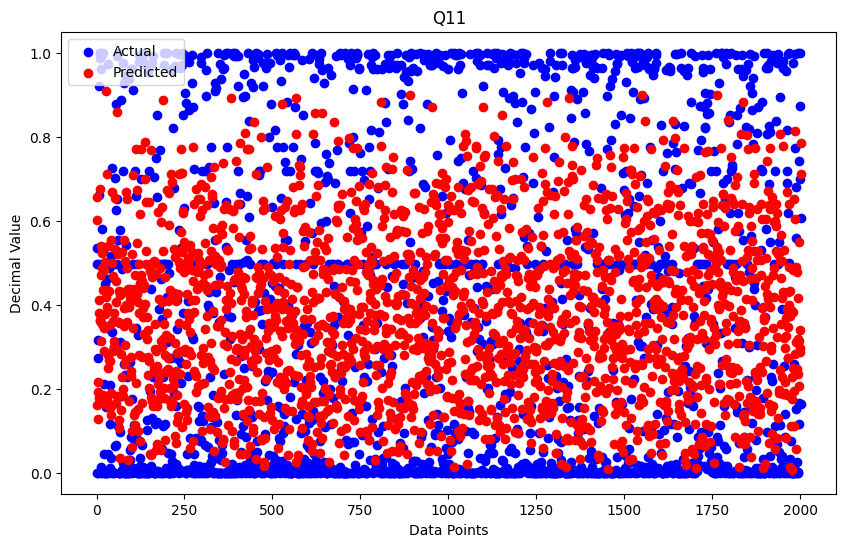

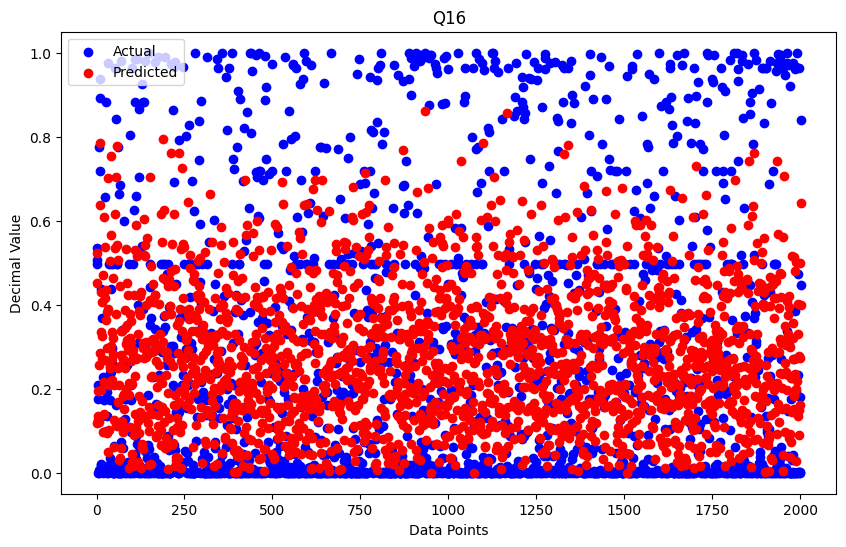

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create a random forest regressor
rf_regressor = RandomForestRegressor()

# Fit the model on the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model (example metric: mean squared error)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error de Random Forest Regressor:", mse)

import matplotlib.pyplot as plt

# Convert y_test to a NumPy array if it's a DataFrame
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.values

# Plotting the results for the first decimal value
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test[:, 0], color='blue', label='Actual')
plt.scatter(range(len(y_test)), y_pred[:, 0], color='red', label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Decimal Value')
plt.title('Q11')
plt.legend()
plt.show()

# Plotting the results for the second decimal value
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test[:, 1], color='blue', label='Actual')
plt.scatter(range(len(y_test)), y_pred[:, 1], color='red', label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Decimal Value')
plt.title('Q16')
plt.legend()
plt.show()


Random Forest Regresor ~ Valeria

Mean Squared Error de Random Forest Regressor: 0.1295060887960176


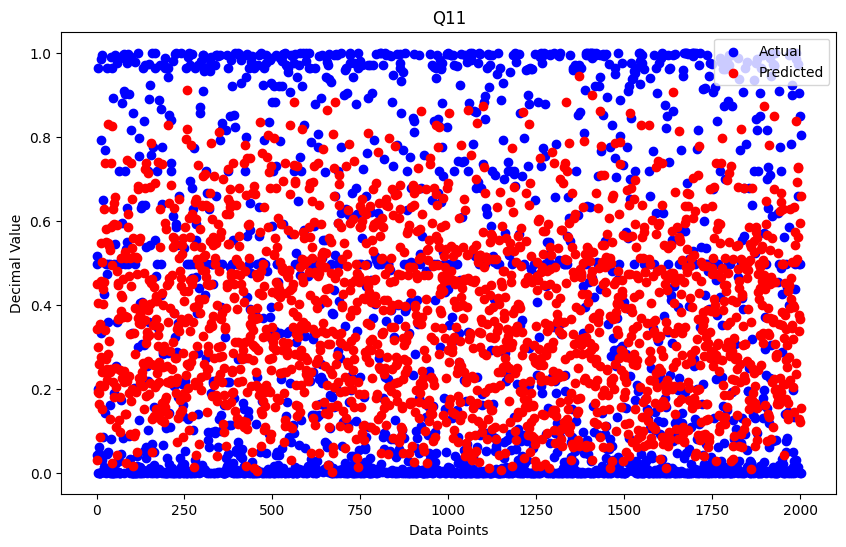

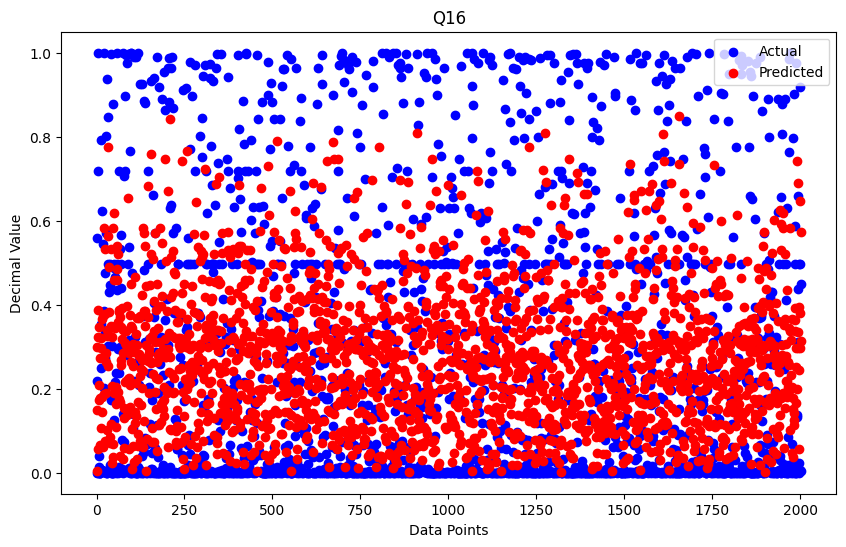

In [48]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create a random forest regressor
rf_regressor = RandomForestRegressor()

# Fit the model on the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model (example metric: mean squared error)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error de Random Forest Regressor:", mse)

import matplotlib.pyplot as plt

# Convert y_test to a NumPy array if it's a DataFrame
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.values

# Plotting the results for the first decimal value
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test[:, 0], color='blue', label='Actual')
plt.scatter(range(len(y_test)), y_pred[:, 0], color='red', label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Decimal Value')
plt.title('Q11')
plt.legend()
plt.show()

# Plotting the results for the second decimal value
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test[:, 1], color='blue', label='Actual')
plt.scatter(range(len(y_test)), y_pred[:, 1], color='red', label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Decimal Value')
plt.title('Q16')
plt.legend()
plt.show()

Random Forest Regresor ~ Victor

Mean Squared Error de Random Forest Regressor: 0.11151217607037052


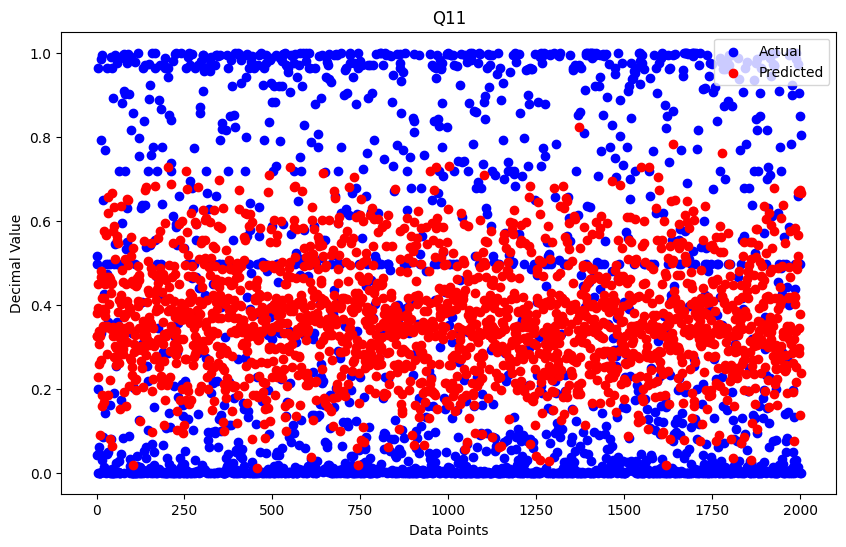

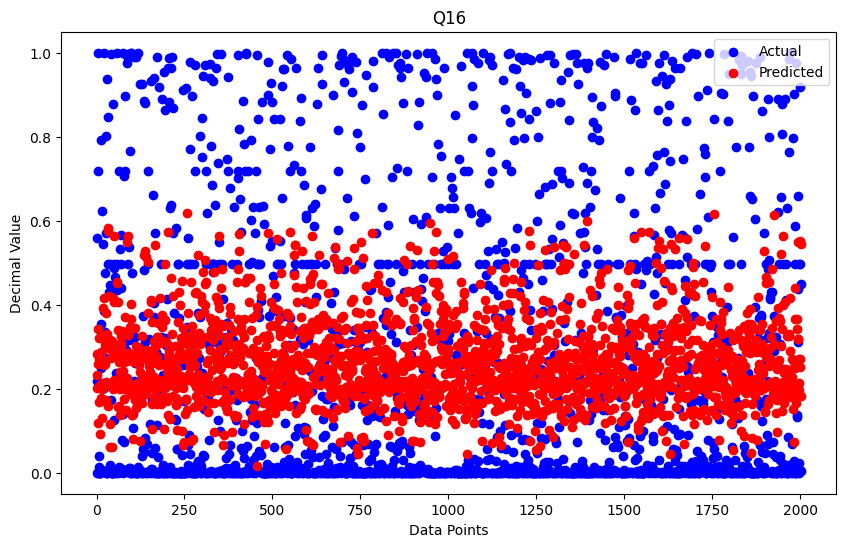

In [49]:
# Create a random forest regressor
rf_regressor = RandomForestRegressor(n_estimators=1000, max_depth=10, min_samples_split = 5, max_features=0.8)

# Fit the model on the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model (example metric: mean squared error)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error de Random Forest Regressor:", mse)

import matplotlib.pyplot as plt

# Convert y_test to a NumPy array if it's a DataFrame
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.values

# Plotting the results for the first decimal value
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test[:, 0], color='blue', label='Actual')
plt.scatter(range(len(y_test)), y_pred[:, 0], color='red', label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Decimal Value')
plt.title('Q11')
plt.legend()
plt.show()

# Plotting the results for the second decimal value
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test[:, 1], color='blue', label='Actual')
plt.scatter(range(len(y_test)), y_pred[:, 1], color='red', label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Decimal Value')
plt.title('Q16')
plt.legend()
plt.show()

Random Forest Regresor ~ Diego

Mean Squared Error de Random Forest Regressor: 0.1327723708878878


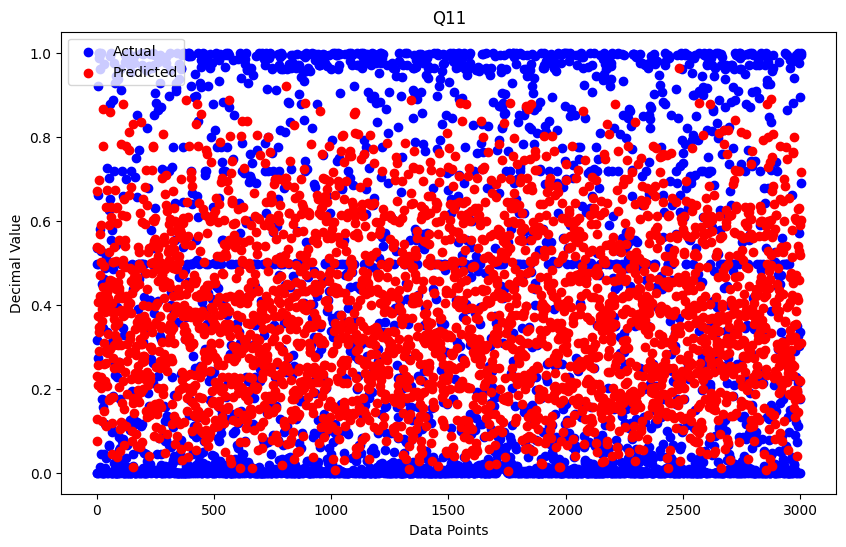

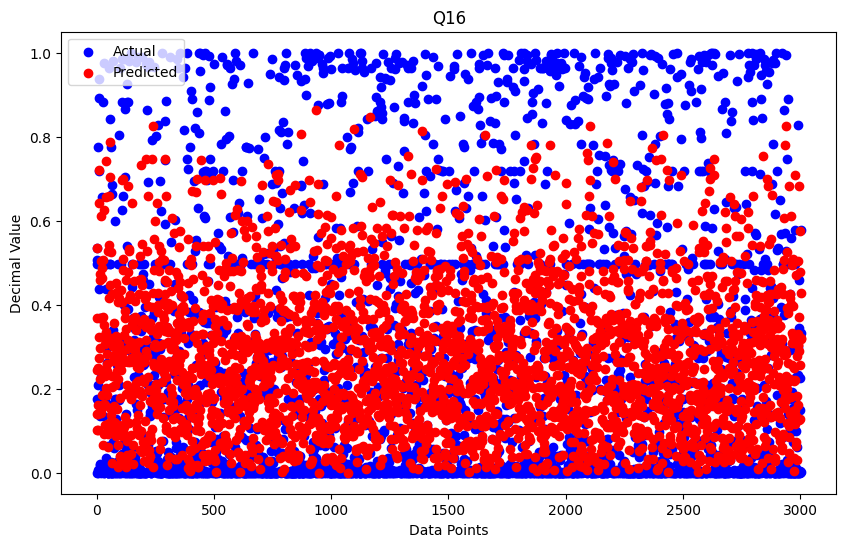

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a random forest regressor
rf_regressor = RandomForestRegressor()

# Fit the model on the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model (example metric: mean squared error)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error de Random Forest Regressor:", mse)

import matplotlib.pyplot as plt

# Convert y_test to a NumPy array if it's a DataFrame
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.values

# Plotting the results for the first decimal value
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test[:, 0], color='blue', label='Actual')
plt.scatter(range(len(y_test)), y_pred[:, 0], color='red', label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Decimal Value')
plt.title('Q11')
plt.legend()
plt.show()

# Plotting the results for the second decimal value
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test[:, 1], color='blue', label='Actual')
plt.scatter(range(len(y_test)), y_pred[:, 1], color='red', label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Decimal Value')
plt.title('Q16')
plt.legend()
plt.show()

Random Forest Regresor ~ Gian

Mean Squared Error de Random Forest Regressor: 0.11232685734661102


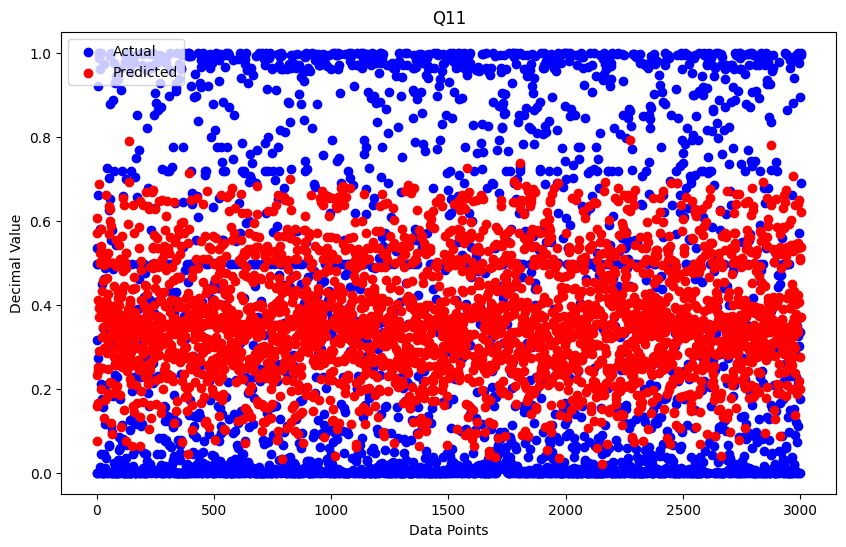

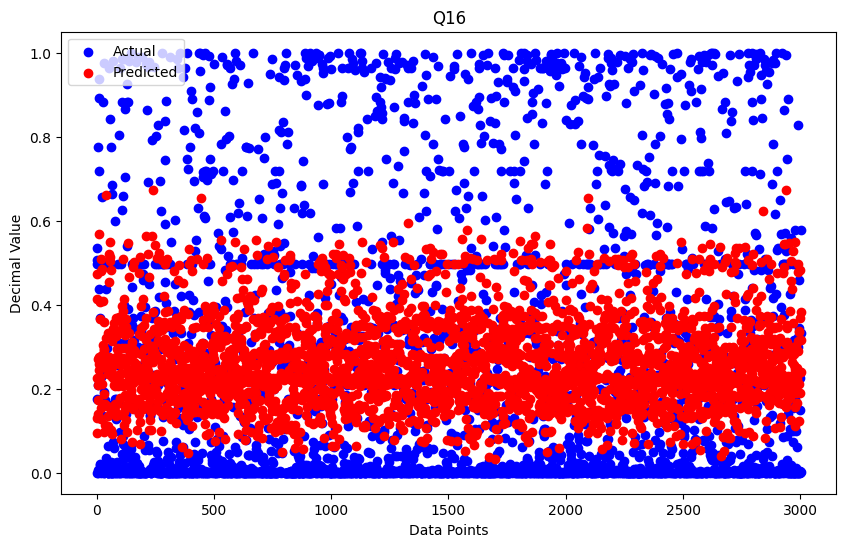

In [51]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a random forest regressor
rf_regressor = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split = 5, max_features=0.8)

# Fit the model on the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model (example metric: mean squared error)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error de Random Forest Regressor:", mse)

import matplotlib.pyplot as plt

# Convert y_test to a NumPy array if it's a DataFrame
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.values

# Plotting the results for the first decimal value
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test[:, 0], color='blue', label='Actual')
plt.scatter(range(len(y_test)), y_pred[:, 0], color='red', label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Decimal Value')
plt.title('Q11')
plt.legend()
plt.show()

# Plotting the results for the second decimal value
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test[:, 1], color='blue', label='Actual')
plt.scatter(range(len(y_test)), y_pred[:, 1], color='red', label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Decimal Value')
plt.title('Q16')
plt.legend()
plt.show()

## K-Means

K-means ~ Gian

In [52]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA   

# Normalizar datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2)

kmeans.fit(scaled_data)

cluster_labels = kmeans.labels_

silhouette_avg = silhouette_score(scaled_data, cluster_labels)

print("Coeficiente de Silueta:", silhouette_avg)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Coeficiente de Silueta: 0.4610549799477016


K-Means ~ Diego

In [53]:
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=1e-4, random_state=42)

# Fit the K-means model to the data
kmeans.fit(scaled_data)

# Get the cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

silhouette_avg = silhouette_score(scaled_data, labels)

print("Coeficiente de Silueta:", silhouette_avg)

Coeficiente de Silueta: 0.4341527630836295


K-Means ~ Valeria

In [54]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=9, max_iter=400, tol=1e-4, random_state=41)

# Fit the K-means model to the data
kmeans.fit(scaled_data)

# Get the cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

silhouette_avg = silhouette_score(scaled_data, labels)

print("Coeficiente de Silueta:", silhouette_avg)

Coeficiente de Silueta: 0.4287948002971128


K-Means ~ Victor

In [55]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=8, max_iter=100, tol=1e-4, random_state=42)

# Fit the K-means model to the data
kmeans.fit(scaled_data)

# Get the cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

silhouette_avg = silhouette_score(scaled_data, labels)

print("Coeficiente de Silueta:", silhouette_avg)

Coeficiente de Silueta: 0.4610549799477016


K-Means ~ Adalia

In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_clusters': [2, 3, 4, 5],
    'init': ['k-means++', 'random'],
    'max_iter': [100, 300, 500]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, cv=3)
grid_search.fit(scaled_data)

# Get the best parameters and best score
best_params = grid_search.best_params_


# Print the best parameters and best score
print("Best Parameters:", best_params)

kmeans = KMeans(n_clusters=5, max_iter=100)

# Fit the K-means model to the data
kmeans.fit(scaled_data)

# Get the cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

silhouette_avg = silhouette_score(scaled_data, labels)

print("Coeficiente de Silueta:", silhouette_avg)

Best Parameters: {'init': 'random', 'max_iter': 100, 'n_clusters': 5}


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Coeficiente de Silueta: 0.4551207720197998


## SVM

SVM ~ Valeria

In [69]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np


# Concatenate the decimal values into a single target variable
y_train_combined = y_train.iloc[:, 0] + y_train.iloc[:, 1]

# Create an SVR model with desired parameters
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Fit the SVR model on the training data
svr.fit(X_train, y_train_combined)

# Make predictions on the test set
y_pred_combined = svr.predict(X_test)

# Separate the predicted combined values into individual decimal values
y_pred = np.column_stack((y_pred_combined, y_pred_combined))

# Evaluate the model (example metric: mean squared error)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error de Support Vector Regressor:", mse)

Mean Squared Error de Support Vector Regressor: 0.18543723106091997


SVM ~ Victor

In [37]:

# Concatenate the decimal values into a single target variable
y_train_combined = y_train.iloc[:, 0] + y_train.iloc[:, 1]

# Create an SVR model with desired parameters
svr = SVR(kernel='sigmoid', C=1.0, epsilon=0.5)

# Fit the SVR model on the training data
svr.fit(X_train, y_train_combined)

# Make predictions on the test set
y_pred_combined = svr.predict(X_test)

# Separate the predicted combined values into individual decimal values
y_pred = np.column_stack((y_pred_combined, y_pred_combined))

# Evaluate the model (example metric: mean squared error)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error de Support Vector Regressor:", mse)

Mean Squared Error de Support Vector Regressor: 2461.9300558247405


SVM ~ Diego

In [38]:
# Concatenate the decimal values into a single target variable
y_train_combined = y_train.iloc[:, 0] + y_train.iloc[:, 1]

# Create an SVR model with desired parameters
svr = SVR(kernel='rbf', C=1.0, epsilon=0.15)

# Fit the SVR model on the training data
svr.fit(X_train, y_train_combined)

# Make predictions on the test set
y_pred_combined = svr.predict(X_test)

# Separate the predicted combined values into individual decimal values
y_pred = np.column_stack((y_pred_combined, y_pred_combined))

# Evaluate the model (example metric: mean squared error)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error de Support Vector Regressor:", mse)

Mean Squared Error de Support Vector Regressor: 0.18594864691680774


SVM ~ Adalia

In [70]:
# Concatenate the decimal values into a single target variable
y_train_combined = y_train.iloc[:, 0] + y_train.iloc[:, 1]

# Create an SVR model with desired parameters
svr = SVR(kernel='sigmoid', C=1.0, epsilon=0.05)

# Fit the SVR model on the training data
svr.fit(X_train, y_train_combined)

# Make predictions on the test set
y_pred_combined = svr.predict(X_test)

# Separate the predicted combined values into individual decimal values
y_pred = np.column_stack((y_pred_combined, y_pred_combined))

# Evaluate the model (example metric: mean squared error)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error de Support Vector Regressor:", mse)

Mean Squared Error de Support Vector Regressor: 2474.4665278546954


SVM ~ Gian

In [71]:
# Concatenate the decimal values into a single target variable
y_train_combined = y_train.iloc[:, 0] + y_train.iloc[:, 1]

# Create an SVR model with desired parameters
svr = SVR(kernel='rbf', C=1.0, epsilon=0.3)

# Fit the SVR model on the training data
svr.fit(X_train, y_train_combined)

# Make predictions on the test set
y_pred_combined = svr.predict(X_test)

# Separate the predicted combined values into individual decimal values
y_pred = np.column_stack((y_pred_combined, y_pred_combined))

# Evaluate the model (example metric: mean squared error)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error de Support Vector Regressor:", mse)

Mean Squared Error de Support Vector Regressor: 0.1792994392932893


## Agrupacion Aglomerativa


Agrupacion Aglomerativa ~ Diego

Coeficiente de silueta: 0.9804905051036832


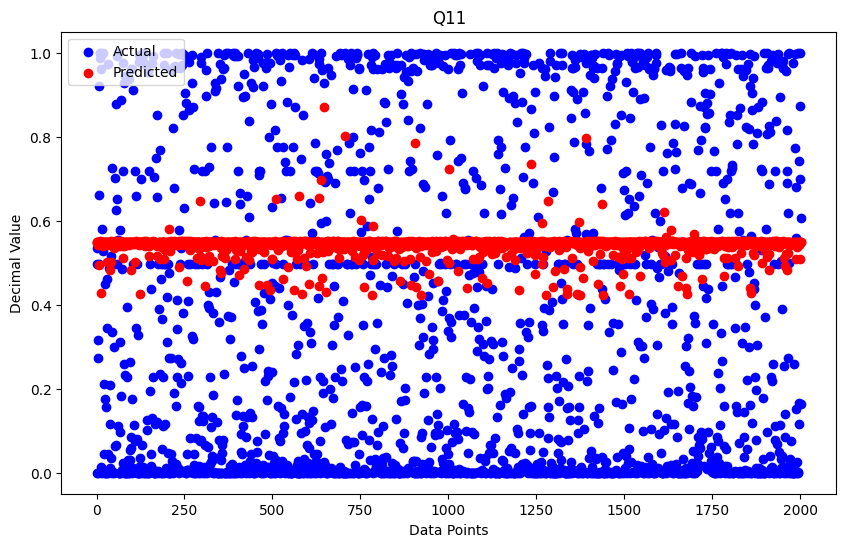

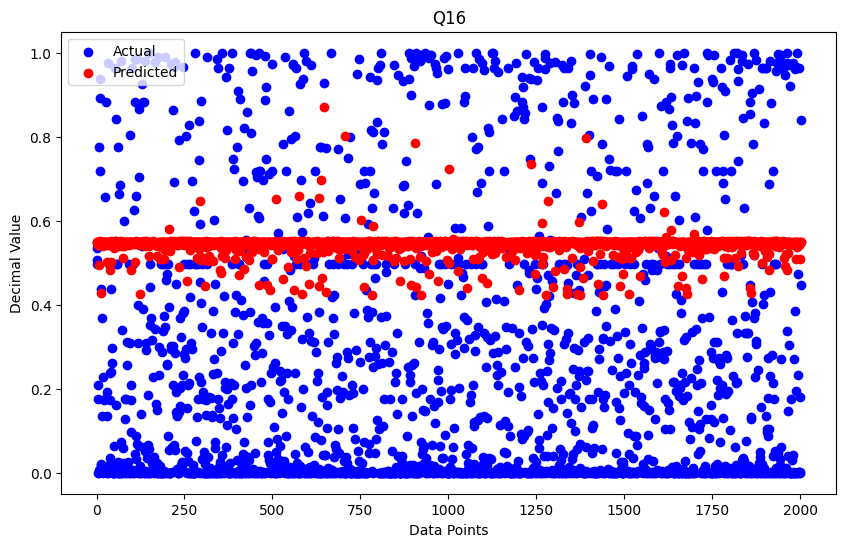

In [72]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# Crear el objeto AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=2)

# Ajustar el modelo a los datos
clustering.fit(X)

# Obtener las etiquetas de los clústeres
labels = clustering.labels_

# Calcular el coeficiente de silueta
silhouette_avg = silhouette_score(X, labels)

# Imprimir el coeficiente de silueta
print("Coeficiente de silueta:", silhouette_avg)


import matplotlib.pyplot as plt
import pandas as pd

# Convert y_test and y_pred to DataFrames
y_test_df = pd.DataFrame(y_test, columns=['Q11', 'Q16'])
y_pred_df = pd.DataFrame(y_pred, columns=['Q11', 'Q16'])

# Plotting the results for the first decimal value
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_df)), y_test_df['Q11'], color='blue', label='Actual')
plt.scatter(range(len(y_test_df)), y_pred_df['Q11'], color='red', label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Decimal Value')
plt.title('Q11')
plt.legend()
plt.show()

# Plotting the results for the second decimal value
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_df)), y_test_df['Q16'], color='blue', label='Actual')
plt.scatter(range(len(y_test_df)), y_pred_df['Q16'], color='red', label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Decimal Value')
plt.title('Q16')
plt.legend()
plt.show()


Agrupacion Aglomerativa ~ Adalia

In [73]:
# Crear el objeto AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=5)

# Ajustar el modelo a los datos
clustering.fit(X)

# Obtener las etiquetas de los clústeres
labels = clustering.labels_

# Calcular el coeficiente de silueta
silhouette_avg = silhouette_score(X, labels)

# Imprimir el coeficiente de silueta
print("Coeficiente de silueta:", silhouette_avg)

Coeficiente de silueta: 0.9675603758671371


Agrupacion Aglomerativa ~ Victor

In [74]:
# Crear el objeto AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=4)

# Ajustar el modelo a los datos
clustering.fit(X)

# Obtener las etiquetas de los clústeres
labels = clustering.labels_

# Calcular el coeficiente de silueta
silhouette_avg = silhouette_score(X, labels)

# Imprimir el coeficiente de silueta
print("Coeficiente de silueta:", silhouette_avg)

Coeficiente de silueta: 0.9673139466902385


Agrupacion Aglomerativa ~ Gian

In [75]:
# Crear el objeto AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=2)

# Ajustar el modelo a los datos
clustering.fit(X)

# Obtener las etiquetas de los clústeres
labels = clustering.labels_

# Calcular el coeficiente de silueta
silhouette_avg = silhouette_score(X, labels)

# Imprimir el coeficiente de silueta
print("Coeficiente de silueta:", silhouette_avg)

Coeficiente de silueta: 0.9804905051036832


Agrupacion Aglomerativa ~ Valeria

In [76]:
# Crear el objeto AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=3,linkage='complete')

# Ajustar el modelo a los datos
clustering.fit(X)

# Obtener las etiquetas de los clústeres
labels = clustering.labels_

# Calcular el coeficiente de silueta
silhouette_avg = silhouette_score(X, labels)

# Imprimir el coeficiente de silueta
print("Coeficiente de silueta:", silhouette_avg)

Coeficiente de silueta: 0.9786570490712245
